In [ ]:
import jax.numpy as jnp
import inspeqtor.experimental as sq
from inspeqtor.legacy import visualization as vis

import qutip
from functools import partial
import matplotlib.pyplot as plt

In [2]:
def format_expectation_values(
    expvals: jnp.ndarray,
) -> dict[str, dict[str, jnp.ndarray]]:
    expvals_dict: dict[str, dict[str, jnp.ndarray]] = {}
    for idx, exp in enumerate(sq.constant.default_expectation_values_order):
        if exp.initial_state not in expvals_dict:
            expvals_dict[exp.initial_state] = {}

        expvals_dict[exp.initial_state][exp.observable] = expvals[idx]

    return expvals_dict


def plot_expectation_values(
    expvals_dict: dict[str, dict[str, jnp.ndarray]],
    title: str,
):
    fig, axes = plt.subplot_mosaic(
        """
        +r0
        -l1
        """,
        figsize=(10, 5),
        sharex=True,
        sharey=True,
    )

    colormap = {
        "X": "#ef4444",
        "Y": "#6366f1",
        "Z": "#10b981",
    }

    for idx, (initial_state, expvals) in enumerate(expvals_dict.items()):
        ax = axes[initial_state]
        for observable, expval in expvals.items():
            ax.plot(expval, "-", label=observable, color=colormap[observable])
        ax.set_title(f"Initial state: {initial_state}")
        ax.set_ylim(-1.05, 1.05)
        ax.legend(loc="upper left")

    # Set title for the figure
    fig.suptitle(title)

    fig.tight_layout()
    return fig, axes

In [19]:
qubit_info = sq.predefined.get_mock_qubit_information()
pulse_sequence = sq.predefined.get_gaussian_pulse_sequence(qubit_info)
dt = 2 / 9
angle = jnp.pi / 2

t_eval = jnp.linspace(
    0,
    pulse_sequence.pulse_length_dt * dt,
    pulse_sequence.pulse_length_dt,
)

array_to_list_of_params_fn, list_of_params_to_array_fn = (
    sq.pulse.get_param_array_converter(pulse_sequence)
)

hamiltonian = partial(
    sq.predefined.rotating_transmon_hamiltonian,
    qubit_info=qubit_info,
    signal=sq.physics.signal_func_v5(
        get_envelope=sq.predefined.get_envelope_transformer(
            pulse_sequence=pulse_sequence
        ),
        drive_frequency=qubit_info.frequency,
        dt=dt,
    ),
)

# hamiltonian = sq.utils.detune_hamiltonian(hamiltonian, 0.0000 * qubit_info.frequency)

whitebox = partial(
    sq.physics.solver,
    t_eval=t_eval,
    hamiltonian=hamiltonian,
    y0=jnp.eye(2, dtype=jnp.complex64),
    t0=0,
    t1=pulse_sequence.pulse_length_dt * dt,
)

params: list[sq.typing.ParametersDictType] = [{"theta": jnp.array(angle)}]
unitary = whitebox(list_of_params_to_array_fn(params))
baseline_expvals = sq.utils.calculate_expectation_values(unitary).T

detune = 0.001

hamiltonian = partial(
    sq.predefined.rotating_transmon_hamiltonian,
    qubit_info=qubit_info,
    signal=sq.physics.signal_func_v5(
        get_envelope=sq.predefined.get_envelope_transformer(
            pulse_sequence=pulse_sequence
        ),
        drive_frequency=qubit_info.frequency * (1 + detune),
        dt=dt,
    ),
)

# hamiltonian = sq.utils.detune_hamiltonian(hamiltonian, detune * qubit_info.frequency)

whitebox = partial(
    sq.physics.solver,
    t_eval=t_eval,
    hamiltonian=hamiltonian,
    y0=jnp.eye(2, dtype=jnp.complex64),
    t0=0,
    t1=pulse_sequence.pulse_length_dt * dt,
)

params: list[sq.typing.ParametersDictType] = [{"theta": jnp.array(angle)}]
unitary = whitebox(list_of_params_to_array_fn(params))
detuned_expvals = sq.utils.calculate_expectation_values(unitary).T

/Users/porametpathumsoot/University/PhD/Projects/espresso/inspeqtor/.venv/lib/python3.11/site-packages/equinox/_jit.py:55: UserWarning: Complex dtype support in Diffrax is a work in progress and may not yet produce correct results. Consider splitting your computation into real and imaginary parts instead.
  out = fun(*args, **kwargs)
/Users/porametpathumsoot/University/PhD/Projects/espresso/inspeqtor/.venv/lib/python3.11/site-packages/equinox/_jit.py:55: UserWarning: Complex dtype support in Diffrax is a work in progress and may not yet produce correct results. Consider splitting your computation into real and imaginary parts instead.
  out = fun(*args, **kwargs)


(<Figure size 2000x1000 with 1 Axes>,
 <Axes: xlabel='Time (dt)', ylabel='Amplitude'>)

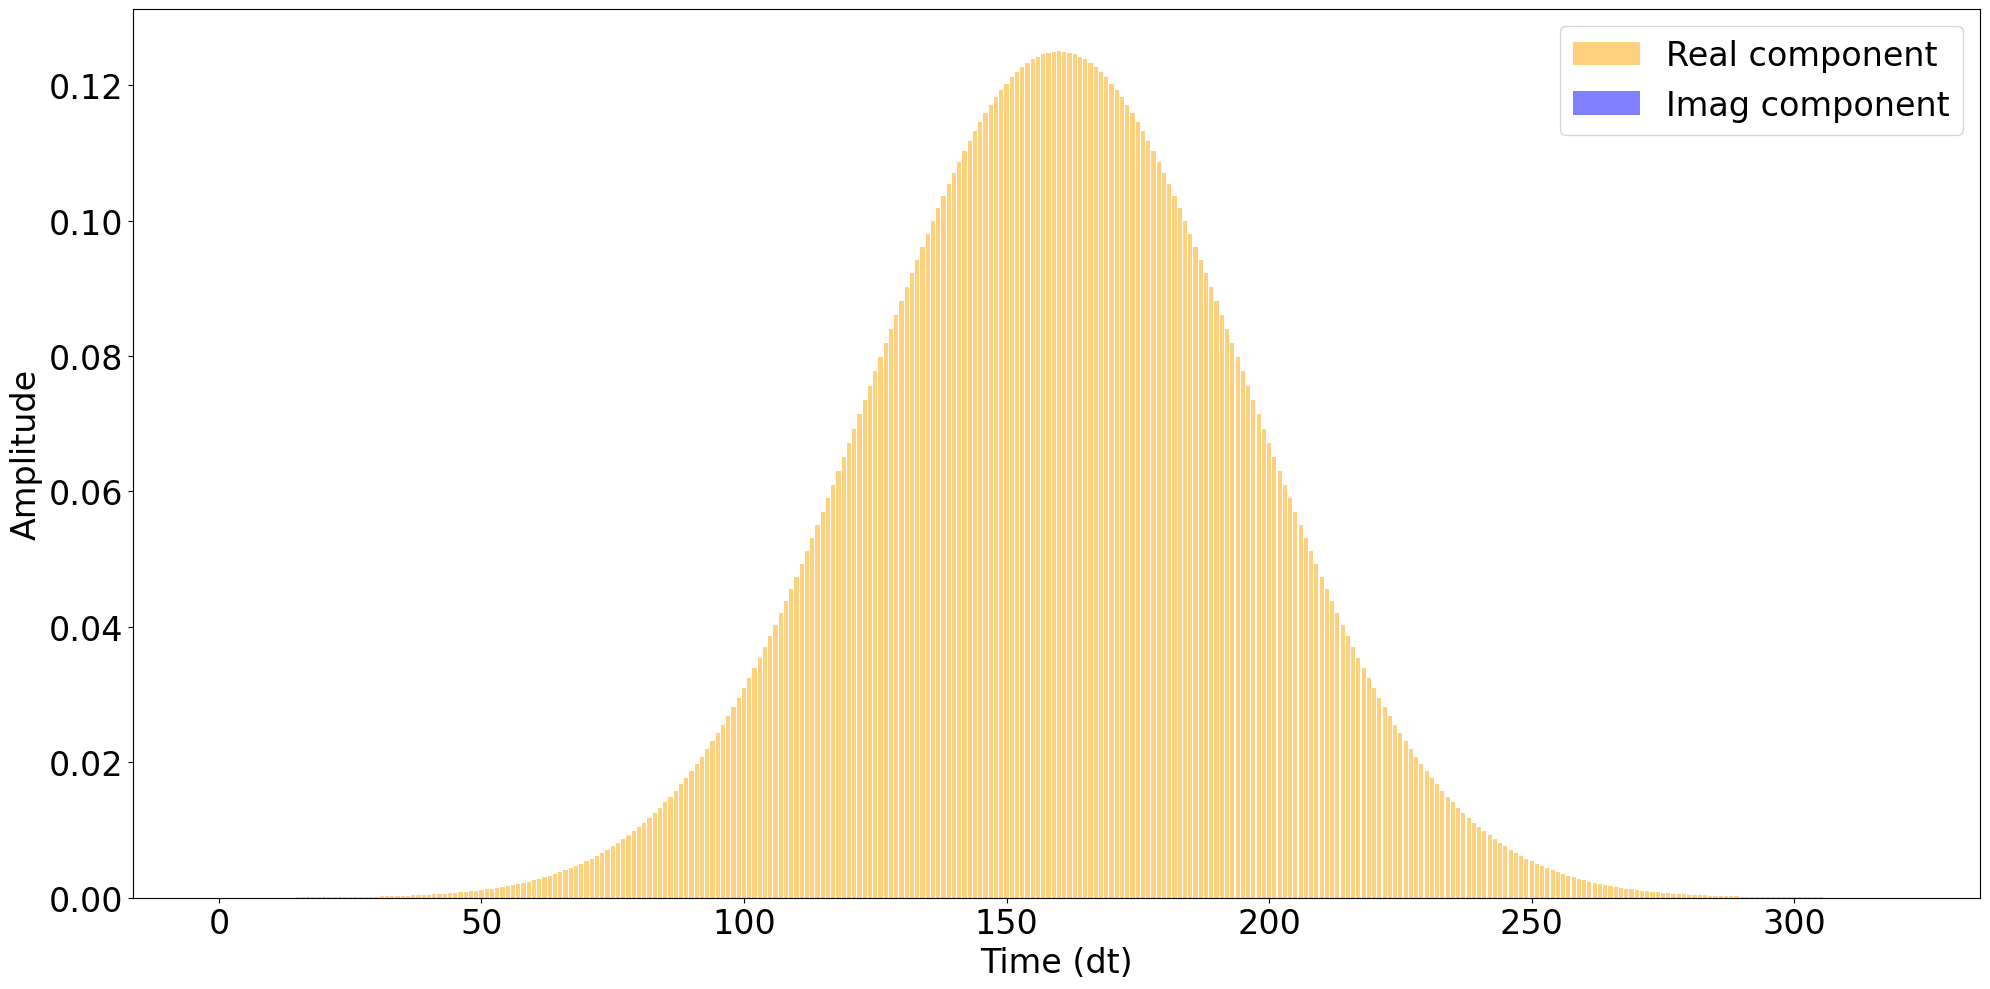

In [20]:
vis.draw_complex_pulse(
    pulse_sequence.get_waveform(params),
    jnp.arange(pulse_sequence.pulse_length_dt),
    font_size=24,
)

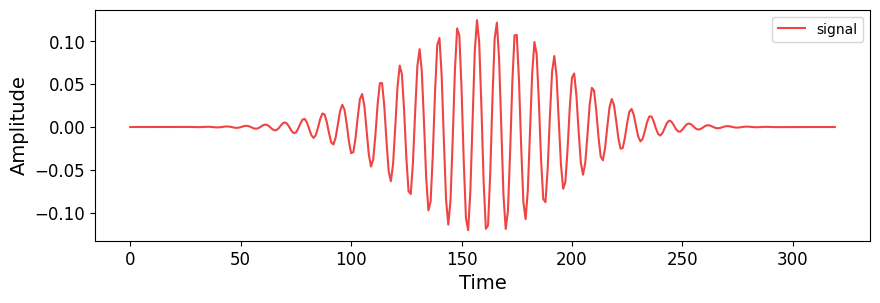

In [21]:
signal = sq.physics.signal_func_v5(
    get_envelope=pulse_sequence.get_envelope,
    drive_frequency=qubit_info.frequency,
    dt=2 / 9,
)(params, t_eval)

fig, ax = plt.subplots(figsize=(10, 3))

ax.plot(signal, label="signal", color="#ef4444")
ax.set_xlabel("Time", fontsize=14)
ax.set_ylabel("Amplitude", fontsize=14)
ax.tick_params(labelsize=12)
ax.legend()

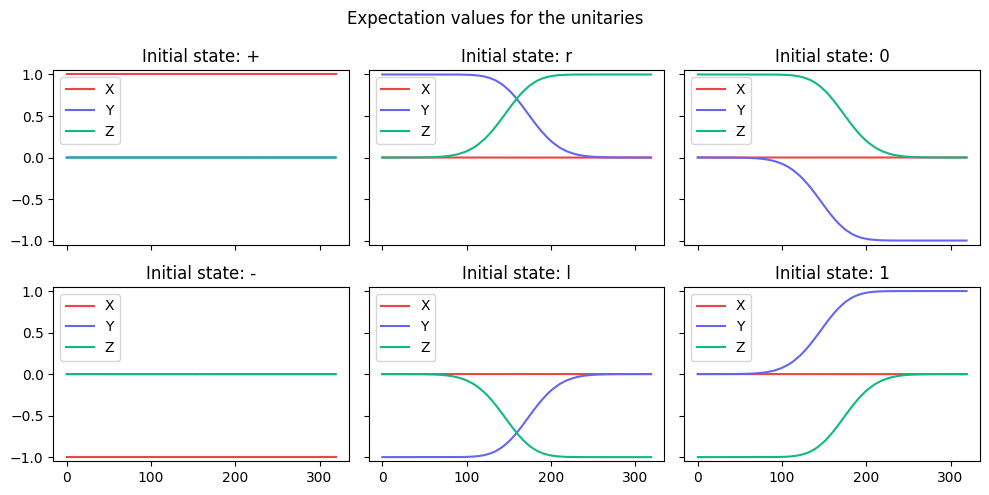

In [22]:
fig, axes = plot_expectation_values(
    format_expectation_values(baseline_expvals), "Expectation values for the unitaries"
)

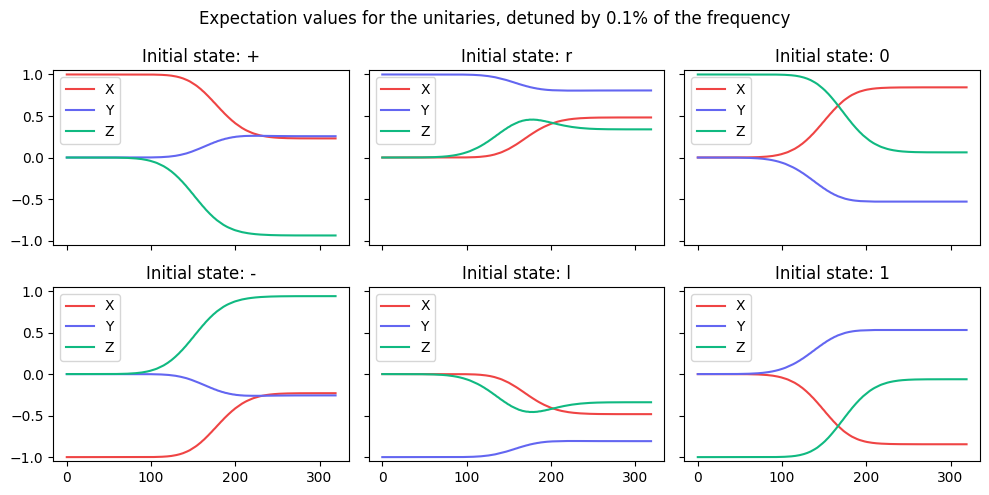

In [23]:
_ = plot_expectation_values(
    format_expectation_values(detuned_expvals),
    f"Expectation values for the unitaries, detuned by {detune * 100}% of the frequency",
)

In [17]:
formtted_detune_expval = format_expectation_values(detuned_expvals)

In [9]:
# For pi / 2 pulse
# The Phase flip error is
phase_flip_error_rate = (
    formtted_detune_expval["+"]["X"][-1] + 1
) / 2 - 1  # NOTE: -1 because the compare to the ideal
# The Bit flip error is
bit_flip_error_rate = (
    formtted_detune_expval["0"]["Z"][-1] + 1
) / 2 - 0.5  # NOTE: 0.5 because the compare to the ideal
# Both
both_flip_error_rate = (formtted_detune_expval["r"]["Y"][-1] + 1) / 2 - 0.5

# Interesting value,
print(f"The error rate is {both_flip_error_rate * 100:.2f}%")
print(f"The error rate is {bit_flip_error_rate * 100: .2f}%")
print(f"The error rate is {phase_flip_error_rate * 100: .2f}%")
jnp.abs((formtted_detune_expval["r"]["Y"][-1] + 1) / 2 - 0.5) + (
    (formtted_detune_expval["0"]["Z"][-1] + 1) / 2 - 0.5
)

The error rate is 40.38%
The error rate is  3.11%
The error rate is -38.49%


Array(0.4348694, dtype=float64)

In [18]:
# For pi pulse
# The Phase flip error is
phase_flip_error_rate = (
    formtted_detune_expval["+"]["X"][-1] + 1
) / 2 - 1  # NOTE: -1 because the compare to the ideal
# The Bit flip error is
bit_flip_error_rate = (
    formtted_detune_expval["0"]["Z"][-1] + 1
) / 2 - 0.0  # NOTE: 0.0 because the compare to the ideal
# Both
both_flip_error_rate = (formtted_detune_expval["r"]["Y"][-1] + 1) / 2 - 0.0

# Interesting value,
print(f"The error rate is {both_flip_error_rate * 100:.2f}%")
print(f"The error rate is {bit_flip_error_rate * 100:.2f}%")
print(f"The error rate is {phase_flip_error_rate * 100:.2f}%")
jnp.abs((formtted_detune_expval["r"]["Y"][-1] + 1) / 2 - 0.5) + (
    (formtted_detune_expval["0"]["Z"][-1] + 1) / 2 - 0.5
)

The error rate is 75.69%
The error rate is 6.69%
The error rate is -81.76%


Array(-0.17625415, dtype=float64)

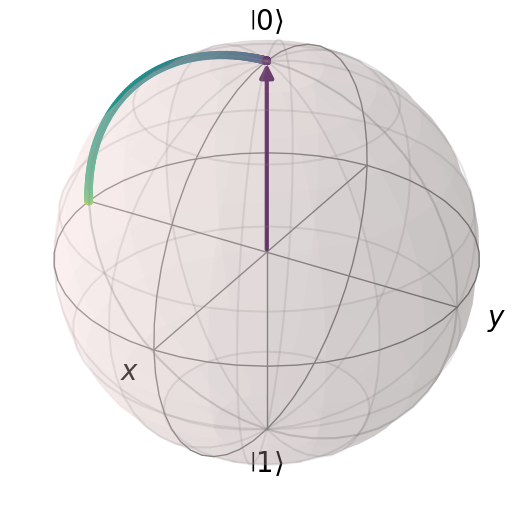

In [145]:
b = qutip.Bloch()

formatted_expval = format_expectation_values(baseline_expvals)

viridis = plt.get_cmap("viridis", 320)
colors = viridis(range(320))

b.add_states(qutip.basis(2, 0), colors="#3e0751")

b.add_points(
    jnp.vstack(
        [
            formatted_expval["0"]["X"],
            formatted_expval["0"]["Y"],
            formatted_expval["0"]["Z"],
        ]
    ),
    meth="m",
    colors=colors,
)

# b.add_points(jnp.vstack(
#     [
#         formatted_expval["r"]["X"],
#         formatted_expval["r"]["Y"],
#         formatted_expval["r"]["Z"],
#     ]
# ))

b.show()